In [1]:
from typing import Generator
from glob import iglob
from itertools import chain

from h5py import File
import numpy as np
import matplotlib.pyplot as plt
from cytoolz import partition
from scipy.fftpack import fft, fftshift
from scipy.optimize import curve_fit
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
from numba import jit

In [2]:
def is_available(filename):
    try:
        with File(filename, 'r'):
            pass
        return True
    except Exception:
        return False


def read_wavelength_at_max(filename: str):
    with File(filename, "r") as f:
        try:
            x0 = 500
            x1 = f["/photon_diagnostics/Spectrometer/Wavelength"][...]
            a = (
                f["/photon_diagnostics/Spectrometer/WavelengthSpan"][...]
                * f["/photon_diagnostics/Spectrometer/Pixel2micron"][...]
                / 1000
            )
            arr = f["/photon_diagnostics/Spectrometer/hor_spectrum"][...]
            _, n = arr.shape
            x = a * (np.arange(n) - x0) + x1
            for tag, y in zip(f['/bunches'], arr):
                yield {"tag": tag, "atmax": x[np.argmax(y)]}
        except KeyError:
            return

In [5]:
filenames = (fn for fn in iglob("/data/TwoPulses/Run_038/rawdata/*.h5") if is_available(fn))
df = (
    from_sequence(filenames)
    .map(read_wavelength_at_max)
    .flatten()
    .to_dataframe()
)
df["phi"] = 1239.84193 / df["atmax"] % 0.0158 / 0.0158 * np.pi
df

,atmax,tag,phi
npartitions=100,,,
,float64,int64,float64
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [6]:
with ProgressBar():
    pdf = df.compute()

[########################################] | 100% Completed | 18.6s


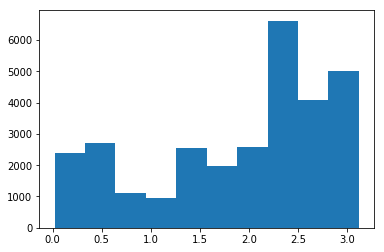

In [7]:
plt.hist(pdf["phi"], bins=10)
plt.show()